## **Initial Setups**

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.applications import efficientnet
from keras.callbacks import ModelCheckpoint
import pandas as pd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## **Download Dataset**

In [3]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [4]:
!unzip -qq /kaggle/working/Flickr8k_Dataset.zip #/content/Flickr8k_Dataset.zip
!unzip -qq /kaggle/working/Flickr8k_text.zip #/content/Flickr8k_text.zip

In [5]:
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

#### To export and save dataset in my local machine

In [6]:
#from google.colab import drive

In [7]:
#rive.mount('/content/gdrive',force_remount=True)

In [8]:
#!cp Flickr8k_Dataset.zip '/content/gdrive/My Drive/'
#!ls -lt '/content/gdrive/My Drive/'

In [9]:
IMAGES_PATH = "Flicker8k_Dataset"
# Fixed batch size
BATCH_SIZE = 64
# Image Size
IMAGE_SIZE = (299,299)
# Number of epochs
EPOCHS = 30
# Vocabulary size
VOCAB_SIZE = 20000 #15000
# Fixed length for any sequence
SEQ_LENGTH = 70
# Dimension for Image embeddings and tokens embeddings
EMBED_DIM = 720
# layer units in feed forward network
FF_DIM = 512
AUTOTUNE = tf.data.AUTOTUNE

## **Preparing the Dataset**

#### Preparing Captions

In [10]:
def load_captions_data(filename):
  # 1002674143_1b742ab4b8.jpg#3	There is a girl with pigtails sitting in front of a rainbow painting .
  # Above is a sample caption. So we iterate each line captions in the file
  with open(filename) as file:
    data = file.readlines()
    # A dictionary that contains the image names with captions
    caption_map = {}
    # A list of all available Captions
    text_data = []
    # A set to identify duplicate and insufficient caption data
    skip_images = set()

    for line in data:
      # Strip image name, .jpg, #caption_number
      line = line.rstrip("\n")
      image_name, caption = line.split("\t")
      image_name = image_name.split("#")[0]
      image_name = os.path.join(IMAGES_PATH, image_name.strip())

      # Split the sentence into Tokens and pass under a conditon to remove too short and long captions
      tokens = caption.strip().split()
      if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
        skip_images.add(image_name)
        continue

      # If a valid caption is obtained, Add a start and end to the caption
      if image_name.endswith("jpg") and image_name not in skip_images:
        caption = "<start> " + caption.strip() + " <end>"
        text_data.append(caption)

        if image_name in caption_map:
          caption_map[image_name].append(caption)
        else:
          caption_map[image_name] = [caption]

      # If any insufficient caption data is in caption_map dict, delete it
    for image_name in skip_images:
      if image_name in caption_map:
        del caption_map[image_name]

  return caption_map, text_data

#### Preparing train test split

In [11]:
def train_test_split(caption_data, train_size = 0.8, shuffle = True):
  all_images = list(caption_data.keys())

  if shuffle is True:
    np.random.shuffle(all_images)

  train_size = int(len(caption_data) * train_size)

  training_data = {
      image_name: caption_data[image_name] for image_name in all_images[:train_size]
  }
  validation_data = {
      image_name: caption_data[image_name] for image_name in all_images[train_size:]
  }

  return training_data, validation_data

In [12]:
caption_map, text_data = load_captions_data("/kaggle/working/Flickr8k.token.txt")
print("Number of text Data : ",len(text_data))
train_data, valid_data = train_test_split(caption_map)
print("Training Samples Size : ", len(train_data))
print("Validation Samples Size : ", len(valid_data))

Number of text Data :  39594
Training Samples Size :  6240
Validation Samples Size :  1561


## **Vectorizing the text Data**

In [13]:
def custom_standardization(input_string):
  lower_string = tf.strings.lower(input_string)
  strip_string = tf.strings.regex_replace(lower_string, "[%s]" % re.escape(strip_chars), "")
  return strip_string

In [14]:
strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")
vectorization = TextVectorization(
    max_tokens = VOCAB_SIZE,
    output_mode = "int",
    output_sequence_length = SEQ_LENGTH,
    standardize = custom_standardization,
)
vectorization.adapt(text_data)

#Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)

## **Build Pipeline**

In [15]:
def decode_resize(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SIZE)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [16]:
def process_input(img_path, captions):
  return decode_resize(img_path), vectorization(captions)

In [17]:
def make_dataset(images, captions):
  dataset = tf.data.Dataset.from_tensor_slices((images, captions))
  dataset = dataset.shuffle(BATCH_SIZE * 8)
  dataset = dataset.map(process_input, num_parallel_calls = AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
  return dataset

In [18]:
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [19]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 70), dtype=tf.int64, name=None))>

## **Building Model**

# Consists of 3 Models
>- CNN Model -> to extract image features
>- TransformersEncoder -> Encode and generate new inputs
>- TransformersDecoder -> Decode and tries to generate captions

In [20]:
def get_cnn_model():
  base_model = efficientnet.EfficientNetB6(
      input_shape = (*IMAGE_SIZE, 3), include_top=False, weights = "imagenet",
  )
  base_model.trainable = False
  base_model_out = base_model.output
  base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
  cnn_model = keras.models.Model(base_model.input, base_model_out)
  return cnn_model

In [21]:
class TransformerEncoderBlock(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.0
    )
    self.attention_2 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim, dropout=0.0
    )
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.dense_1 = layers.Dense(embed_dim, activation = "relu")

  def call(self, inputs, training, mask = None):
    inputs = self.layernorm_1(inputs)
    inputs = self.dense_1(inputs)
    attention_output_1 = self.attention_1(
        query = inputs,
        value = inputs,
        key = inputs,
        attention_mask = None,
        training = training,
    )
    out_1 = self.layernorm_2(inputs + attention_output_1)
    return out_1
    attention_output_2 = self.attention_2(
        query=out_1, value=out_1, key=out_1, attention_mask=None, training=training
    )
    out_2 = self.layernorm_1(out_1 + attention_output_2)  # Apply layer norm before final output

    return out_2

  def get_config(self):
    config = super(TransformerEncoderBlock, self).get_config()
    config.update({
        "embed_dim":self.embed_dim,
        "dense_dim":self.dense_dim,
        "num_heads":self.num_heads,
        "attention_1":self.attention_1,
        "layernorm_1":self.layernorm_1,
        "layernorm_2":self.layernorm_2,
        "dense_1":self.dense_1
    })
    return config


In [22]:
class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
    super().__init__(**kwargs)
    self.token_embeddings = layers.Embedding(
        input_dim = vocab_size, output_dim = embed_dim
    )
    self.position_embeddings = layers.Embedding(
        input_dim = sequence_length, output_dim = embed_dim
    )
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start = 0, limit = length, delta = 1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_tokens = embedded_tokens *  self.embed_scale
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  def get_config(self):
    config = super(PositionalEmbedding, self).get_config()
    config.update({
        "token_embeddings":self.token_embeddings,
        "position_embeddings":self.position_embeddings,
        "sequence_length":self.sequence_length,
        "vocab_size":self.vocab_size,
        "embed_dim":self.embed_dim,
        "embed_scale":self.embed_scale
    })
    return config

  def compute_mask(self, inputs, mask = None):
    return tf.math.not_equal(inputs, 0)

In [23]:
class TransformerDecoderBlock(layers.Layer):
  def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.ff_dim = ff_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.1
    )
    self.attention_2 = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.1
    )
    self.attention_3 = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.1
    )
    self.attention_4 = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.1
    )

    self.ffn_layer_1 = layers.Dense(ff_dim, activation = "relu")
    self.ffn_layer_2 = layers.Dense(embed_dim)

    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.layernorm_4 = layers.LayerNormalization()
    self.layernorm_5 = layers.LayerNormalization()

    self.embedding = PositionalEmbedding(
        embed_dim = EMBED_DIM, sequence_length = SEQ_LENGTH, vocab_size = VOCAB_SIZE
    )
    self.out = layers.Dense(VOCAB_SIZE, activation = "softmax")

    self.dropout_1 = layers.Dropout(0.3)
    self.dropout_2 = layers.Dropout(0.5)
    self.supports_masking = True

  def call(self, inputs, encoder_outputs, training, mask = None):
    inputs = self.embedding(inputs)
    causal_mask = self.get_causal_attention_mask(inputs)

    if mask is not None:
      padding_mask = tf.cast(mask[:,:,tf.newaxis], dtype = tf.int32)
      combined_mask = tf.cast(mask[:,tf.newaxis,:], dtype = tf.int32)
      combined_mask = tf.minimum(combined_mask, causal_mask)

    attention_output_1 = self.attention_1(
        query = inputs,
        value = inputs,
        key = inputs,
        attention_mask = combined_mask,
        training = training,
    )
    out_1 = self.layernorm_1(inputs + attention_output_1)

    attention_output_2 = self.attention_2(
        query = out_1,
        value = encoder_outputs,
        key = encoder_outputs,
        attention_mask = padding_mask,
        training = training,
    )
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    attention_output_3 = self.attention_3(
        query = out_2,
        value = out_2,
        key = out_2,
        attention_mask = causal_mask,
        training = training,
    )
    out_3 = self.layernorm_3(out_2 + attention_output_3)

    ffn_out = self.ffn_layer_1(out_2)
    ffn_out = self.dropout_1(ffn_out, training = training)
    ffn_out = self.ffn_layer_2(ffn_out)

    ffn_out = self.layernorm_4(ffn_out + out_3, training = training)
    ffn_out = self.dropout_2(ffn_out, training = training)

    attention_output_4 = self.attention_4(
        query = ffn_out,
        value = ffn_out,
        key = ffn_out,
        attention_mask = causal_mask,
        training = training,
    )

    ffn_out = self.layernorm_5(ffn_out + attention_output_4)
    preds = self.out(ffn_out)
    return preds

  def get_config(self):
    config = super(TransformerDecoderBlock, self).get_config()
    config.update({
        "embed_dim":self.embed_dim,
        "ff_dim":self.ff_dim,
        "num_heads":self.num_heads,
        "attention_1":self.attention_1,
        "attention_2":self.attention_2,
        "attention_3":self.attention_3,
        "attention_4":self.attention_4,
        "ffn_layer_1":self.ffn_layer_1,
        "ffn_layer_2":self.ffn_layer_2,
        "layernorm_1":self.layernorm_1,
        "layernorm_2":self.layernorm_2,
        "layernorm_3":self.layernorm_3,
        "layernorm_4":self.layernorm_4,
        "layernorm_5":self.layernorm_5,
        "embedding":self.embedding,
        "out":self.out,
        "dropout_1":self.dropout_1,
        "dropout_2":self.dropout_2,
        "supports_masking":self.supports_masking,

    })
    return config

  def get_causal_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype = "int32")
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype = tf.int32)],
        axis = 0,
    )
    return tf.tile(mask, mult)

In [24]:
class ImageCaptioningModel(keras.Model):
  def __init__(self,cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.image_aug = image_aug
    self.cnn_model = cnn_model
    self.loss_tracker = keras.metrics.Mean(name = "loss")
    self.acc_tracker = keras.metrics.Mean(name = "accuracy")
    self.num_captions_per_image = num_captions_per_image

  def config(self):
    config = super(ImageCaptioningModel, self).get_config()
    config.update({
        "encoder":self.encoder,
        "decoder":self.decoder,
        "image_aug":self.image_aug,
        "cnn_model":self.cnn_model,
        "loss_tracker":self.loss_tracker,
        "acc_tracker":self.acc_tracker,
        "num_captions_per_image":self.num_captions_per_image
    })
    return config

  def calculate_loss(self, y_true, y_pred, mask):
    loss = self.loss(y_true, y_pred)
    mask = tf.cast(mask, dtype = loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

  def calculate_accuracy(self, y_true, y_pred, mask):
    accuracy = tf.equal(y_true, tf.argmax(y_pred, axis = 2))
    accuracy = tf.math.logical_and(mask, accuracy)
    accuracy = tf.cast(accuracy, dtype = tf.float32)
    mask = tf.cast(mask, dtype = tf.float32)
    return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

  def _compute_caption_loss_acc(self, img_embed, batch_seq, training = True):
    encoder_out = self.encoder(img_embed, training = training)
    batch_seq_inp = batch_seq[:,:-1]
    batch_seq_true = batch_seq[:,1:]
    mask = tf.math.not_equal(batch_seq_true,0)
    batch_seq_pred = self.decoder(
        batch_seq_inp, encoder_out, training = training, mask = mask
    )
    loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
    acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
    return loss, acc

  def train_step(self, batch_data):
    batch_img, batch_seq = batch_data
    batch_loss = 0
    batch_acc = 0
    if self.image_aug:
      batch_img = self.image_aug(batch_img)
    img_embed = self.cnn_model(batch_img)

    for i in range(self.num_captions_per_image):
      with tf.GradientTape() as tape:
        loss, acc = self._compute_caption_loss_acc(img_embed, batch_seq[:,i,:], training = True)
        batch_loss += loss
        batch_acc += acc

      train_weights = (
          self.encoder.trainable_variables + self.decoder.trainable_variables
      )

      grads = tape.gradient(loss, train_weights)
      self.optimizer.apply_gradients(zip(grads, train_weights))

    batch_acc /= float(self.num_captions_per_image)
    self.loss_tracker.update_state(batch_loss)
    self.acc_tracker.update_state(batch_acc)
    return {"loss" : self.loss_tracker.result(), "acc" : self.acc_tracker.result()}

  def test_step(self, batch_data):
    batch_img, batch_seq = batch_data
    batch_loss = 0
    batch_acc = 0
    img_embed = self.cnn_model(batch_img)

    for i in range(self.num_captions_per_image):
      loss, acc = self._compute_caption_loss_acc(img_embed, batch_seq[:,1,:], training = False)
      batch_loss += loss
      batch_acc += acc
    batch_acc /= float(self.num_captions_per_image)

    self.loss_tracker.update_state(batch_loss)
    self.acc_tracker.update_state(batch_acc)

    return {"loss" : self.loss_tracker.result(), "acc" : self.acc_tracker.result()}

  @property
  def metrics(self):
    return [self.loss_tracker, self.acc_tracker]

In [25]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=2)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=4)

165234480/165234480 [==============================] - 1s 0us/step


In [26]:
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder,image_aug=image_augmentation
)

## **Model Training**

In [27]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits = False, reduction = "none"
)

early_stopping = keras.callbacks.EarlyStopping(restore_best_weights = True)
checkpoint = ModelCheckpoint(filepath = "kaggle/working/best_weight.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)


In [28]:
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,post_warmup_learning_rate, warmup_steps):
    super().__init__()
    self.post_warmup_learning_rate = post_warmup_learning_rate
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    global_step = tf.cast(step, tf.float32)
    warmup_steps = tf.cast(self.warmup_steps, tf.float32)
    warmup_progress = global_step / warmup_steps
    warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
    return tf.cond(
        global_step < warmup_steps,
        lambda: warmup_learning_rate,
        lambda: self.post_warmup_learning_rate,
    )

In [29]:
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate = 1e-4, warmup_steps = num_warmup_steps)

In [30]:
caption_model.compile(optimizer = keras.optimizers.Adam(lr_schedule), loss = cross_entropy)

In [31]:
#!pip install tensorboard

In [32]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

## accuracy & parameters
EfficientNetB0
- epochs = 30 -> accuracy = 48%
- epochs = 50 -> accuracy = 64%

EfficientNetB4 (+1 attention)
- epochs = 30 -> accuracy = 57%

EfficientNetB6 (+1 attention)
- epochs = 30 -> accuracy = 59%
- epochs = 30 -> val accuracy = 42%

EfficientNetB6 (+1 attention) (embed, FF dim = 720)
- epochs 11 -> accuracy = 56%
- epochs = 42 -> accuracy = 71%

In [33]:
accuracy = []
loss = []
caption_model.fit(
    train_dataset,
    epochs = 16,
    validation_data = valid_dataset,
    callbacks = checkpoint, #[early_stopping],
)

Epoch 1/16
98/98 [==============================] - ETA: 0s - loss: 27.3305 - acc: 0.1449
Epoch 1: val_acc improved from -inf to 0.33721, saving model to kaggle/working/best_weight.hdf5
98/98 [==============================] - 293s 3s/step - loss: 27.3305 - acc: 0.1456 - val_loss: 19.4110 - val_acc: 0.3372
Epoch 2/16
98/98 [==============================] - ETA: 0s - loss: 18.3182 - acc: 0.3325
Epoch 2: val_acc improved from 0.33721 to 0.38177, saving model to kaggle/working/best_weight.hdf5
98/98 [==============================] - 244s 2s/step - loss: 18.3182 - acc: 0.3326 - val_loss: 17.0640 - val_acc: 0.3818
Epoch 3/16
98/98 [==============================] - ETA: 0s - loss: 16.4486 - acc: 0.3675
Epoch 3: val_acc improved from 0.38177 to 0.39795, saving model to kaggle/working/best_weight.hdf5
98/98 [==============================] - 245s 2s/step - loss: 16.4486 - acc: 0.3675 - val_loss: 16.1333 - val_acc: 0.3979
Epoch 4/16
98/98 [==============================] - ETA: 0s - loss: 15

In [35]:
metrics = {"Accuracy": [caption_model.history.history['acc'][-1],caption_model.history.history['val_acc'][-1]], "Loss": [caption_model.history.history['loss'][-1], caption_model.history.history['val_loss'][-1]]}
df_metrics = pd.DataFrame(data = metrics, index=["Training", "Validation"])
df_metrics

,Accuracy,Loss
Training,0.539128,9.566608
Validation,0.426985,15.675289


In [36]:
train_acc = caption_model.history.history['acc']
train_loss = caption_model.history.history['loss']
val_acc = caption_model.history.history['val_acc']
val_loss = caption_model.history.history['val_loss']

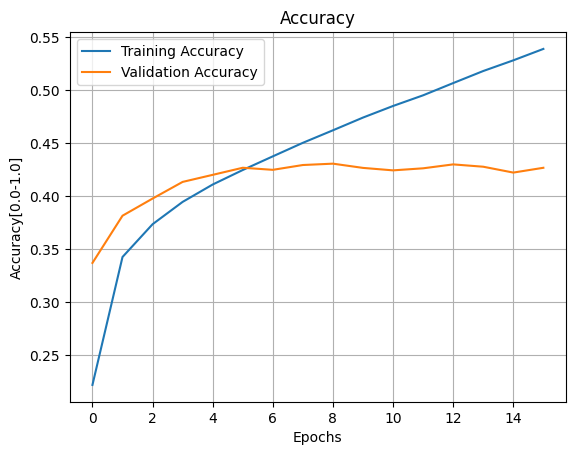

In [38]:
epochs = [i for i in range(1, len(accuracy)+1)] 
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy[0.0-1.0]")
plt.grid()
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Accuracy")
plt.show()

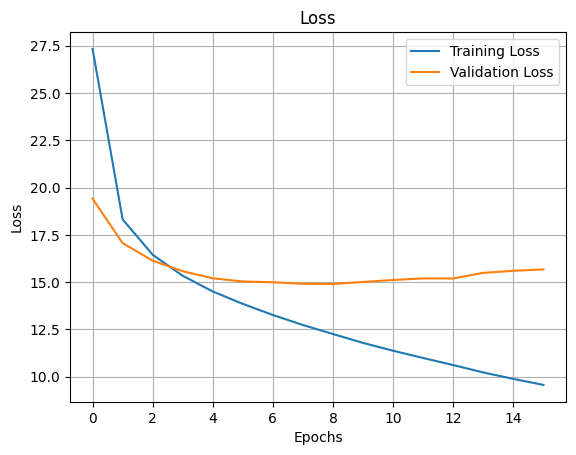

In [39]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.grid()
plt.title("Loss")
plt.show()

In [40]:
caption_model.layers

In [42]:
caption_model.save_weights(filepath = "/kaggle/working/50_epochs_weight")

In [44]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

In [51]:
def generate_caption(img=None):
    model = caption_model
    if img is not None:
        sample_img = img
    else:
        sample_img = np.random.choice(valid_images)
    sample_img = decode_resize(sample_img)
    img = sample_img.numpy().clip(0,255).astype(np.uint8)
    plt.imshow(img)
    plt.show()
    img = tf.expand_dims(sample_img, 0)
    img = model.cnn_model(img)
    encoded_img = model.encoder(img, training = False)
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:,:-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = model.decoder(
        tokenized_caption, encoded_img, training = False, mask = mask
        )
        sampled_token_index = np.argmax(predictions[0,i,:])
        sampled_token = index_lookup[sampled_token_index]

        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption : ", decoded_caption)
    return decoded_caption

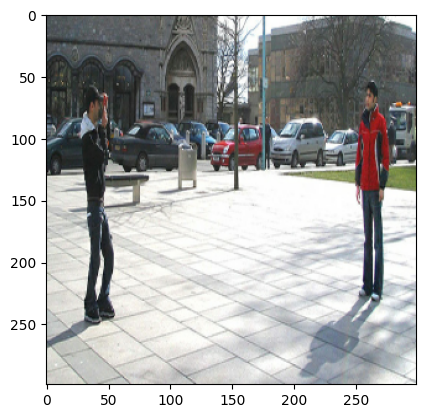

Predicted Caption :  a man in a red jacket stands in front of a building


'a man in a red jacket stands in front of a building'

In [52]:
img  = "/kaggle/input/model-test-bleu/1213336750_2269b51397.jpg"
generate_caption(img)


## BLEU SCORE

In [2]:
!pip install sacrebleu

  Obtaining dependency information for sacrebleu from https://files.pythonhosted.org/packages/de/a5/bf9eddf90deeb7833bbb1ecd7cd4515245cc54c330b936d502ac531f9412/sacrebleu-2.4.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.3 MB/s eta 0:00:00
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/17/9e/87671efcca80ba6203811540ed1f9c0462c1609d2281d7b7f53cef05da3d/portalocker-2.8.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 5.2 MB/s eta 0:00:00


In [35]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu

# Define your desired weights (example: higher weight for bi-grams)
weights = (0.25, 0.25, 0.25, 0.25) # Weights for uni-gram, bi-gram, tri-gram, and 4-gram

# Reference and predicted texts (same as before)
reference = [["A", "man", "in", "a", "black", "jacket", "is","taking" ,"a", "photo","of" ,"a", "man", "in", "a" ,"red","jacket"],
["A" ,"man" ,"in" ,"a" ,"black", "outfit" ,"is", "taking", "a" ,"photograph", "of" ,"a", "man", "in","a", "red", "jacket"],
["A" ,"man", "takes", "a", "picture", "of", "another" ,"man", "in", "an", "open", "area", "just", "off" ,"of", "a", "busy", "street"],
["A", "young", "man", "taking", "a", "picture", "of", "another", "young" ,"man", "outdoors"],
["Young", "man", "takes", "picture", "of", "another", "young" ,"man", "in", "front", "of", "church"]
                                 ]
predictions = ["a", "man", "in", "a", "red", "jacket", "stands", "in", "front", "of", "a", "building"]

# Calculate BLEU score with weights
score_1 = sentence_bleu(reference, predictions, weights=(0.25,0,0,0))
score_2 = sentence_bleu(reference, predictions, weights=(0.25,0.25,0,0))
score_3 = sentence_bleu(reference, predictions, weights=(0.25,0.25,0.25,0))
score_4 = sentence_bleu(reference, predictions, weights=(0.25,0.25,0.25,0.25))
print("BLEU_1 score:", score_1)
print("BLEU_1 - BLEU_2 score:", score_2)
print("BLEU_1 - BLEU_3 score:", score_3)
print("BLEU_1 - BLEU_4 score:", score_4)
BLEU_metrics = {"BLEU-1":score_1, "BLEU-2": score_2, "BLEU-3":score_3, "BLEU-4":score_4}
df_bleu = pd.DataFrame(data=BLEU_metrics, index=["Proposed model"])
df_bleu

BLEU_1 score: 0.9554427922043668
BLEU_1 - BLEU_2 score: 0.8823258718645414
BLEU_1 - BLEU_3 score: 0.7419446627365011
BLEU_1 - BLEU_4 score: 0.5637560315259289


,BLEU-1,BLEU-2,BLEU-3,BLEU-4
Proposed model,0.955443,0.882326,0.741945,0.563756


In [ ]:
cnn_model_new = get_cnn_model()
encoder_new = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder_new = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

# Load the weights from the .h5 file
weights_path = "/kaggle/working/kaggle/working/best_weight.hdf5"

# Load the CNN model weights
cnn_model_new.load_weights(weights_path, by_name=True)

# Create the ImageCaptioningModel instance
untrained_model = ImageCaptioningModel(
    cnn_model=cnn_model_new,
    encoder=encoder,
    decoder=decoder,
    num_captions_per_image=5,
    image_aug=image_augmentation,
)

In [ ]:
untrained_model.cnn_model.build(weights_path)
untrained_model.encoder.build(weights_path)
untrained_model.decoder.build(weights_path)


In [ ]:
img = None
for _ in range(5):
    generate_caption(untrained_model, img)